# Reeb Graph Matching
#### Implementing 'Topology Matching for Fully Automatic Similarity Estimation of 3D Shapes'
#### http://graphics.stanford.edu/courses/cs468-08-fall/pdf/Hilaga01.pdf
#### (Hilaga et al., 2001)

In [1]:
import numpy as np
import os
from os.path import isfile, join
from os import listdir
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csd_functions
import scipy
import networkx as nx
import reeb_matching
from copy import deepcopy
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as hcluster
import random
sns.set()


Load tree data

In [2]:
prefix = 'gbarEvPyrAmpa_sweep'

data_dir = os.path.abspath('../lfp_reeb_github/data')
name = 'gbarEvPyrAmpa_sweep10'
node_points, node_connectivity = reeb_matching.load_tree(data_dir,prefix,name)


Compute multiresoluion reeb graph

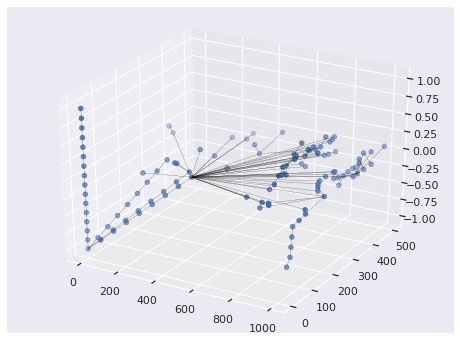

In [3]:
%matplotlib inline
G = nx.Graph()
G.add_edges_from(node_connectivity)

node_attributes = {node_id : {'Position' : node_points[node_id,:], 'Visited' : 0, 'Merged':[],'Inserted':[],'New_Merge':[]} for node_id in list(G.nodes)}
nx.set_node_attributes(G,node_attributes)

interval_dict = reeb_matching.compute_intervals(node_points, 16)
seed_node = list(G.nodes)[1]
reeb_matching.graph_search(G, seed_node, interval_dict,0)
reeb_matching.plot_graph(G)

G.clear()

Compute Similarity 

In [4]:
# data_dir = os.path.abspath('../lfp_reeb_github/data')
# prefix = 'gbarEvPyrAmpa_sweep'

# s_dir = data_dir + '/' + prefix + '/' + 'skeleton/'
# file_list = reeb_matching.get_skeleton_names(s_dir)

# file_list

# resolution_list = [8,4,2]

# similarity_matrix, MPAIR_list = reeb_matching.tree_sim_matrix(file_list, resolution_list, data_dir, prefix)


In [5]:
# plt.figure(figsize=(5,5))
# sns.set_style('darkgrid',{'axes.grid' : False})
# plt.imshow(similarity_matrix,vmin=0, vmax=1)
# plt.title('Topographic Similarity Matrix')
# plt.colorbar()
# plt.show()

Plot similarity matrix from file

In [6]:
w_similarity_matrix = np.array(pd.read_csv('../data/gbarEvPyrAmpa_merge/similarity_matrices/similarity_matrix_reeb.csv',header=None))
w_similarity_matrix = 1 - w_similarity_matrix/np.max(w_similarity_matrix)

#Make symmetric wrt upper triangle
i_lower = np.tril_indices(w_similarity_matrix.shape[0], -1)
w_similarity_matrix[i_lower] = w_similarity_matrix.T[i_lower]

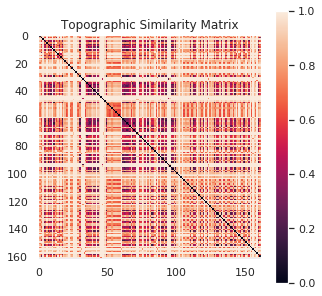

In [7]:
%matplotlib inline
plt.figure(figsize=(5,5))
sns.set_style('darkgrid',{'axes.grid' : False})
plt.imshow(w_similarity_matrix)
plt.title('Topographic Similarity Matrix')
plt.colorbar()
plt.show()

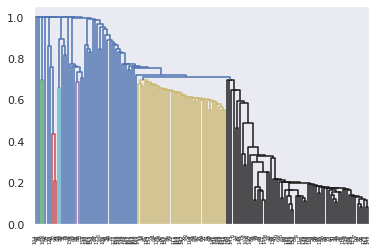

In [8]:
%matplotlib qt
for i in range(w_similarity_matrix.shape[0]):
    w_similarity_matrix[i,i] = 0

distVec = ssd.squareform(w_similarity_matrix)
linkage = hcluster.linkage(distVec)
plt.figure()
dendro  = hcluster.dendrogram(linkage)


In [9]:
%matplotlib inline
# cluster_indeces = hcluster.fcluster(linkage, t=4, criterion='maxclust')
cluster_indeces = hcluster.fcluster(linkage, t=1.153, criterion='inconsistent')

cluster_labels = np.unique(cluster_indeces)
p_dir = ['../lfp_reeb_github/data/gbarEvPyrAmpa_sweep/points', '../lfp_reeb_github/data/gbarEvPyrAmpa_reversed_inputs/points']
flist1, flist2 = np.array(os.listdir(p_dir[0])), np.array(os.listdir(p_dir[1]))
p_dir_array = np.repeat(p_dir, [len(flist1),len(flist2)])
file_list = np.concatenate([flist1,flist2])

num_selection = 4

cluster_labels



array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51],
      dtype=int32)

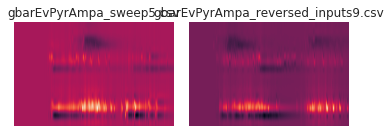

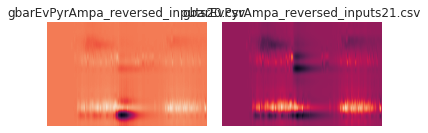

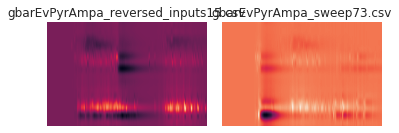

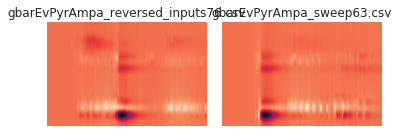

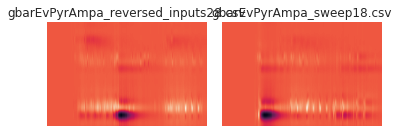

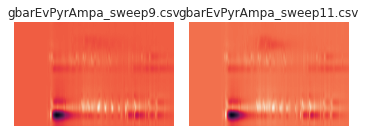

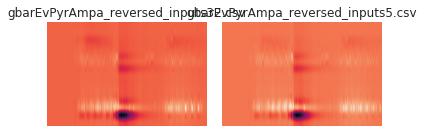

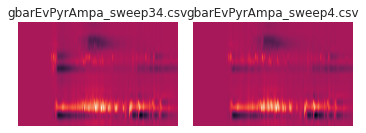

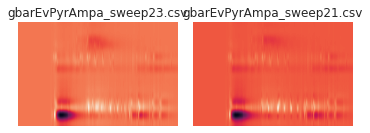

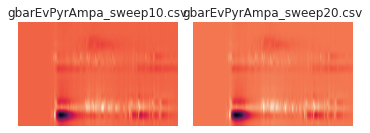

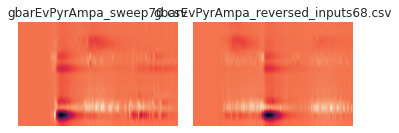

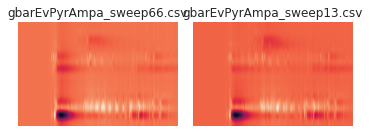

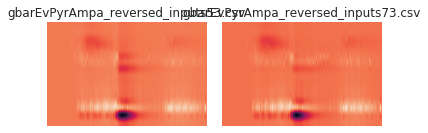

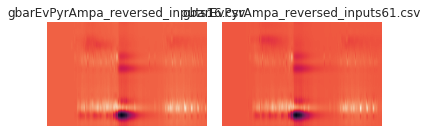

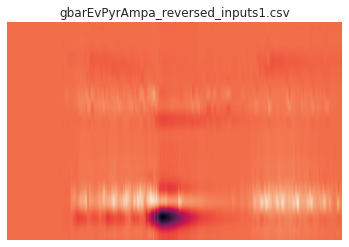

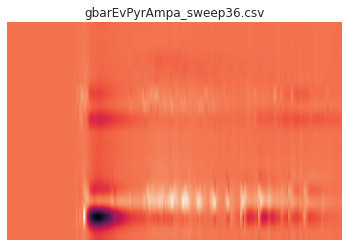

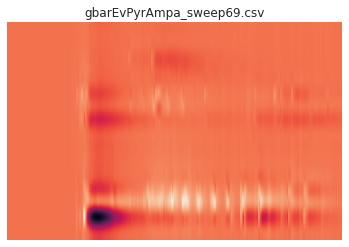

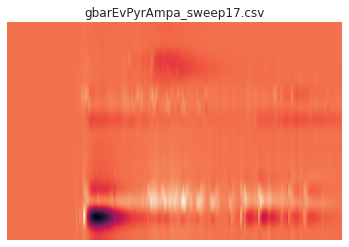

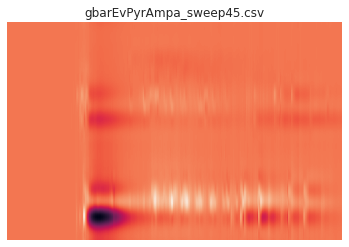

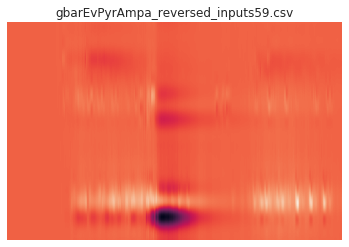

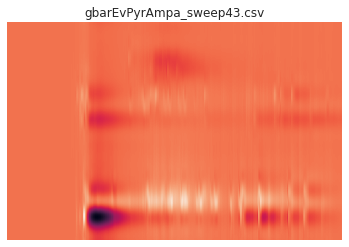

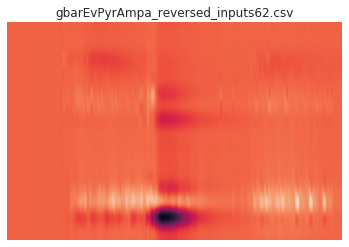

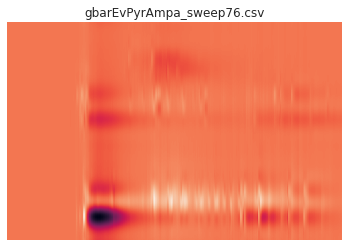

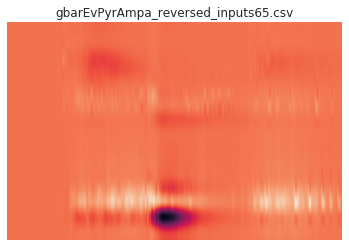

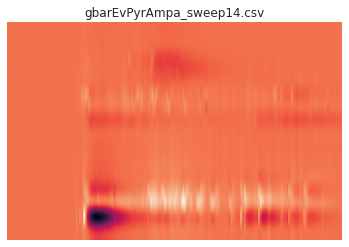

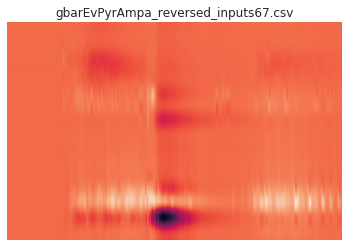

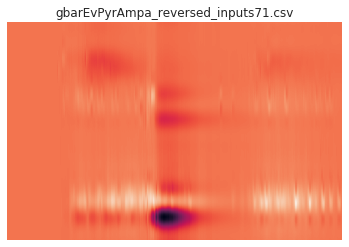

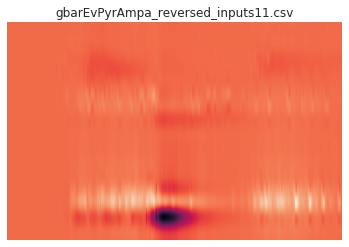

ParserError: Error tokenizing data. C error: Expected 3 fields in line 406096, saw 214


In [10]:
for label in cluster_labels:
    file_cluster = file_list[cluster_indeces == label]
    file_indeces = np.nonzero(cluster_indeces == label)[0]

    num_files = len(file_cluster)
    if num_files < num_selection:
        num_selection = num_files

    rand_choice = random.sample(np.arange(np.size(file_cluster)).tolist(), num_selection)

    num_rc = np.ceil(np.sqrt(num_selection)).astype(int)

    count = 1
    plt.figure()
    # for f in range(np.size(file_cluster)):
    for f in rand_choice:
        f_path = p_dir_array[file_indeces[f]] + '/' + file_cluster[f]

        plt.subplot(num_rc,num_rc,count)
        csd_grid = csd_functions.points2grid(np.array(pd.read_csv(f_path)))
        plt.imshow(csd_grid,aspect='auto')
        plt.axis('off')
        plt.title(file_cluster[f])
        
        count += 1
    
    # plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()